# Unsupervised Learning Methods
## Outline 
#### 1. Text similarity: cosine similarity, summary extraction
#### 2. Text clusttering: KNN, visualization with PCA, t-SNE, MDS
#### 3. Build Recommender System

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import plotly.express as px

from scipy.stats import entropy
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS

import re
import string

In [8]:
# download and create the stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english')) | set(stopwords.words('french')) | set(stopwords.words('italian')) | set(stopwords.words('german')) | set(stopwords.words('portuguese')) | set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ymsc1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# get reviews and perform text vectorization

def get_reviews_vectorized(top_n=-1, ngram_range=(1, 1), max_features=1000):
    df = pd.read_pickle("asset/reviews20221010.pkl")
    df = df.dropna()
    df = df.groupby(['wine ID', 'year']).agg({
        'Review': lambda x : ' '.join(x),
        'name':'unique',
        'country':'unique', 
        'winery': 'unique',
        'price': 'unique',
        'rating': 'unique'
        })
    df.reset_index(inplace=True)
    df = df.astype("string")
    df[['price','rating']] = df[['price','rating']].apply(lambda x: x.str[1:-1])
    df[['name', 'country', 'winery']] = df[['name', 'country', 'winery']].apply(lambda x: x.str[2:-2])
    review_instances = df.Review.replace('\d+'," ", regex=True)
    review_instances = review_instances.replace(r'\n',' ', regex=True)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=max_features,
        min_df=10,
        stop_words=stopwords_list,
        ngram_range=ngram_range,
        use_idf=True,
    )
    if top_n >= 0:
        review_instances = review_instances.values[0:top_n]
        df = df[0:top_n]
    else:
        review_instances = review_instances.values


    X = vectorizer.fit_transform(review_instances)

    return (X, vectorizer, review_instances, df)

In [10]:
(X, vectorizer, review_instances, df) = get_reviews_vectorized(-1, (1, 2))

## 1. Text similarity

In [11]:
cosine_similarities = linear_kernel(X, X)

In [12]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []
    
    # Find the index of the input
    idx = indices[indices == name].index[0]
    
    # Find the wines with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])
    
    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])
    
    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
    
    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new



def sample():
    select = df.sample(n=1)
    name = select['name'].item()
    print('Select %s ' % name)
    
    return select



def make_wordcloud(text):
    # Generate a word cloud image
    text = text
    wordcloud = WordCloud().generate(text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [13]:
select = sample()
select

Select Fleurie 2017 


,wine ID,year,Review,name,country,winery,price,rating
418,78495,2017,"Red fruits, berries. Herbaceous, light, acidic...",Fleurie 2017,France,Trénel,17.91720205,3.6


In [14]:
select_name = select.name.item()
recomendation = recommend(select_name)
recomendation

Top 10 wines like Fleurie 2017 with similar reviews: 


,country,winery,price,rating,wine ID,year,Review
Cuvée Marcel 2018,France,Domaine Marcel Lapierre,48.02979808,4.3,1750282,2018,Wow I love this. Only made in outstanding vint...
Morgon Côte du Py 2018,France,Jean Foillard,44.10899824,4.3,1105335,2018,First red of the tasting and suggested as perf...
Brouilly 2018,France,Domaine Bonnet-Cotton,24.01489904,4.2,4630455,2018,"Appearance: Cloudy, medium ruby. Nose: Clean,..."
Delys Morgon 2020,France,Daniel Bouland,43.91634202,4.1,4177406,2020,In Paris you go 100% silvuble. A smooth red wi...
Cuvée Vieilles Vignes Brouilly 2018,France,Domaine de la Grand'Cour - Jean Louis Dutraive,48.91197804,4.1,3238542,2018,Nice Beaujolais had the 2019 recently and this...
Côte de Brouilly Les Sept Vignes 2020,France,Château Thivin,44.63303011,4.1,4898671,2020,"Deep ruby colour. Aromas of cherry, raspberry,..."
Côte de Brouilly 2018,France,Domaine Bonnet-Cotton,24.40697902,4.1,3744193,2018,Wow! What a gamay; juicy with cherry cola and ...
Fleurie 2020,France,Dominique Piron,27.51570315,4.1,1784142,2020,This understated berry flavoured Fleurie snuck...
Les Vieilles Vignes Moulin-a-Vent 2017,France,Thibault Liger-Belair,27.4455989,4.1,1197475,2017,"This needed about 2hrs to really open up, but ..."
Régnié 2018,France,Julien Sunier,24.50499902,4.,1209965,2018,"Enjoyable and bright, as Beaujolais should be...."


This is the wordcloud of the select wine looks like...


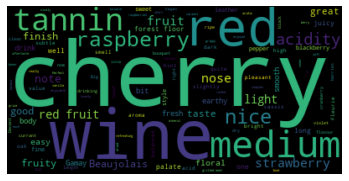

This is the wordcloud of the first recommendation looks like...


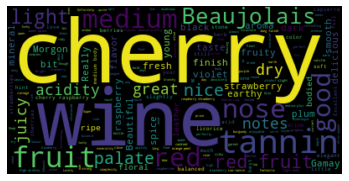

In [15]:
recomendation_1_review = recomendation.iloc[0].Review
select_review = select.Review.item()
print('This is the wordcloud of the select wine looks like...')
make_wordcloud(select_review)
print('This is the wordcloud of the first recommendation looks like...')
make_wordcloud(recomendation_1_review)

## 2. Text clusttering

#### Firstly, try k-means by two categories.

In [16]:
def kmeans_review_k_2():
    result = None
   
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    features = vectorizer.get_feature_names()    
    sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]    
    top10_clust1 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[0]][:10]
    top10_clust2 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[1]][:10]
    result = [top10_clust1, top10_clust2]

    return result


kmeans_review_k_2()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['bordeaux',
  'merlot',
  'cassis',
  'blackcurrant',
  'syrah',
  'cabernet',
  'malbec',
  'cab',
  'black currant',
  'shiraz'],
 ['lemon',
  'pear',
  'peach',
  'champagne',
  'bubbles',
  'green apple',
  'honey',
  'yellow',
  'grapefruit',
  'chardonnay']]

#### Interesting! It seems the k-means finds two discrete categories, the "red" and the "white"! There are more categories for wines! <br>We want to explore the optimal number of clusters using the elbow method. 

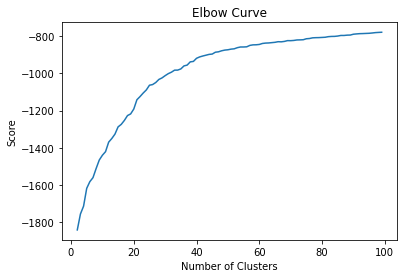

In [17]:
# elbow curve for exploring k values for KNN 
X_ar = X.toarray()
Nc = range(2, 100)
kmeans = [KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=42) for i in Nc]
kmeans
score = [kmeans[i].fit(X_ar).score(X_ar) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#### The optimal number of clustters is near 30. We set k=30 for the K-means. <br>Next, we want create labels for each cluster by extracting discrete words in the reviews of each wine.

In [18]:
def compute_distinctive_term_score(T, T_a):
    # First compute information gain.
    IG = entropy(T) - entropy(T_a)

    # if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms those whose *absence* is notable,
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG
    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))
    return result

In [19]:
def answer_cluster_labeling(n_clusters=7):
    result = None

    X_ar = X.toarray()
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    ig = np.empty([n_clusters, 1000])
    for c in range(n_clusters):
        tc = one_vs_all_count_matrix(centroids, c).sum(axis=1)/one_vs_all_count_matrix(centroids, c).sum(axis=1).sum(axis=0)
        for w in range(1000):
            tw = one_vs_all_count_matrix(centroids, c)[:,w]/one_vs_all_count_matrix(centroids, c).sum(axis=0)[w]
            ig[c,w] = compute_distinctive_term_score(tc, tw)
    features = vectorizer.get_feature_names()    
    sorted_ig_idx = ig.argsort(axis=1)[:,::-1] 
    result = []
    for c in range(n_clusters):
        result.append([features[feature_idx] for feature_idx in sorted_ig_idx[c]][:5])
    return result


answer_cluster_labeling(30)

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['blanc', 'quince', 'grenache', 'rhone', 'peach pear'],
 ['chocolate oak',
  'italian',
  'cherry chocolate',
  'italy',
  'chocolate vanilla'],
 ['mousse', 'fine bubbles', 'brut', 'biscuit', 'yeasty'],
 ['eucalyptus', 'drop', 'chocolate oak', 'plum blackberry', 'mocha'],
 ['bordeaux', 'second wine', 'petit verdot', 'verdot', 'bordeaux blend'],
 ['tempranillo',
  'spanish',
  'vanilla leather',
  'leather vanilla',
  'vanilla tobacco'],
 ['rhône', 'rhone', 'olive', 'olives', 'deep purple'],
 ['natural',
  'cru',
  'strawberry cherry',
  'pomegranate',
  'raspberry strawberry'],
 ['saline', 'pear lemon', 'white wine', 'pear apple', 'salt'],
 ['verdot', 'petit verdot', 'inky', 'bordeaux blend', 'final'],
 ['cab franc', 'franc', 'cabernet franc', 'cabernet', 'cf'],
 ['bubbly', 'brut', 'fine bubbles', 'bubbles', 'mousse'],
 ['burgundy',
  'strawberry cherry',
  'raspberry strawberry',
  'raspberry cherry',
  'forest floor'],
 ['rose', 'pink', 'salmon', 'strawberries', 'strawberry raspberr

In [22]:
def answer_manifold_a():
    result = None

    # YOUR CODE HERE
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    pca = PCA(n_components=2, random_state = 42)
    X_pca = pca.fit_transform(X_ar)
    
    tsne = TSNE(n_components=2, random_state = 42)
    X_tsne = tsne.fit_transform(X_ar)
    
    mds = MDS(n_components=2, random_state = 42)
    X_mds = mds.fit_transform(X_ar)

    result = (X_pca, X_tsne, X_mds)
    return result

X_pca, X_tsne, X_mds = answer_manifold_a()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


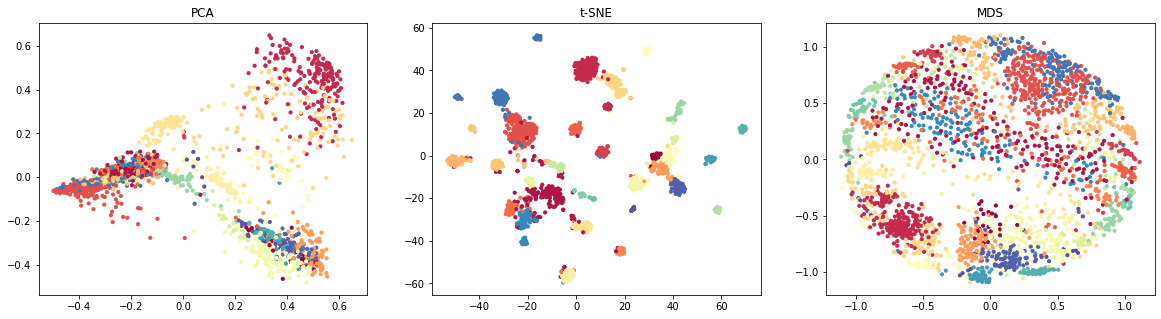

In [24]:
def plot_manifolds():
    colors = cm.Spectral(np.linspace(0, 1, 30))
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y])
    axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color=colors[y])
    axes[2].scatter(X_mds[:, 0], X_mds[:, 1], s=10, color=colors[y])

    axes[0].set_title("PCA")
    axes[1].set_title("t-SNE")
    axes[2].set_title("MDS")
    plt.show()

plot_manifolds()

#### Same visualizations build on Plotly. Enjoy the interactive experiences!

In [30]:
def scatterplot_by_plotly(X, manifolds, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_manifolds = pd.DataFrame(manifolds, columns=['x', 'y'])
    df_manifolds['labels'] = labels
    df_plot = pd.concat([df_manifolds, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

In [32]:
scatterplot_by_plotly(X, X_pca, "PCA")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [33]:
scatterplot_by_plotly(X, X_tsne, "t-SNE")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [34]:
scatterplot_by_plotly(X, X_mds, "MDS")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## 3. Build Recommender System

In [ ]:
def recommend_knn(name):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_knn = df.copy()
    df_knn['labels'] = labels

    select_label = df_knn[df_knn.name == name].sample(n=1)['labels']
    df_new = df_knn[df_knn.labels == select_label]
    
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new

In [ ]:
def get_mean_vector(wine_list):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)
    vectors = []
    
    for wine in wine_list:
        idx = indices[indices == wine].index[0]
        vector = km.transform(X_ar[idx].reshape(1, -1))
        vectors.append(vector)  
    
    song_matrix = np.array(list(vectors))
    return np.mean(song_matrix, axis=0)




def recommend_knn(wine_list):
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)

    # Find the wines with a similar cosine-sim value and order them from bigges number
    wine_center = get_mean_vector(wine_list).reshape(1, -1)
    wine_data = km.transform(X_ar)

    distances = cdist(wine_center, wine_data, 'cosine')

    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(np.argsort(distances)[:, :30][0])


    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])

    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])

    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))

    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)

    print('Top wines like with similar reviews according to the user list: ')

    return df_new




def sample_list(n=5):
    select = df.sample(n)
    for i in range(n):
        name = select.name.iloc[i]
        print('Select %s ' % name)
    
    return select

In [ ]:
user_sample = sample_list(5)
user_list = user_sample.name.tolist()
user_sample

Select Machete 2018 
Select Sauvignon Blanc 2021 
Select Extra-Brut Champagne Grand Cru N.V. 
Select Les Rocheuses 2016 
Select Blanc de Blancs Champagne Premier Cru N.V. 


,wine ID,year,Review,name,country,winery,price,rating
1894,2178596,2018,"violet ink in the glass, with a nose of black ...",Machete 2018,United States,Orin Swift,50.,4.4
2178,5374519,2021,👁 pale yellow color 👃aromas of citrus and tr...,Sauvignon Blanc 2021,New Zealand,Pā Road,13.62477946,4.1
1719,1755737,N.V.,"Walnut, hazelnut and bakery flavour; apricot a...",Extra-Brut Champagne Grand Cru N.V.,France,Lamiable,34.11095864,3.9
2259,6254112,2016,"3,8. Tasted blind and fast. Closed aroma, a bi...",Les Rocheuses 2016,France,Château le Rey,47.51258044,4.
284,23275,N.V.,Opened a magnum of this with friends. I'd brou...,Blanc de Blancs Champagne Premier Cru N.V.,France,Larmandier-Bernier,49.990198,4.1


In [ ]:
recomendation_list = recommend_knn(user_list)
recomendation_list

Top wines like with similar reviews according to the user list: 


,country,winery,price,rating,wine ID,year,Review
Blanc de Blancs Extra Brut N.V.,France,EPC Champagne,34.20897863,4.2,7585407,N.V.,4.3 very similar to the signature millesime. T...
Vermouth de Chambéry Dry N.V.,France,Dolin,20.31042832,4.1,1406124,N.V.,Makes a great Manhattan. I used Buffalo Trace ...
De Nit Rosado 2017,Spain,Raventós i Blanc,25.,4.1,1610937,2017,Soft rosé in color. Sweet and gentle in nose. ...
Brut Supréme Champagne N.V.,France,Royal Riviera,35.19450403,4.,3307938,N.V.,"Creamy apricot, yellow floral, dried white che..."
Cava Gran Reserva Brut Nature Reserva de la Familia 2017,Spain,Juvé & Camps,16.66339933,4.,1136856,2017,"When in Spain, you start obviously with Cava, ..."
Stella Pink N.V.,Italy,Stella Rosa,12.99,4.,2006166,N.V.,"Strong red berries flavor, very refreshing, we..."
Or Blanc Blanc de Blancs Champagne N.V.,France,Benoit Cocteaux,24.01489904,4.,3555658,N.V.,4- Blanc de blancs from 3 anneè 36 months sur ...
Garden Spritz N.V.,Argentina,CHANDON Argentina,18.62379926,3.9,9618321,N.V.,While not a pure wine in the truest sense of t...
Almond N.V.,United States,Wilson Creek,21.99,3.9,1137888,N.V.,Great way to make sparkling wine easy to drink...
Château Tour Léognan Pessac-Léognan 2019,France,Château Carbonnieux,14.60497942,3.9,1148420,2019,"Dry, Green Apple. Perfect! On the nose very co..."


This is the wordcloud of the first sample looks like...


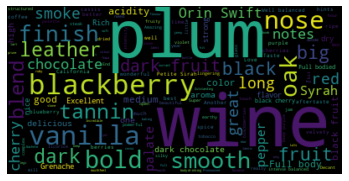

This is the wordcloud of the first recommendations looks like...


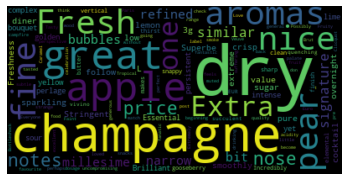

In [ ]:
user_sample_1_review = user_sample.iloc[0].Review
print('This is the wordcloud of the first sample looks like...')
make_wordcloud(user_sample_1_review)
recomendation_1_review = recomendation_list.iloc[0].Review
print('This is the wordcloud of the first recommendations looks like...')
make_wordcloud(recomendation_1_review)